# <span style="font-family:cursive;text-align:center"><font color=red> Site-Energy Usage Intensity Prediction(EUI) </span>
------------------------------------------------------------------------------------------------------------------------------------------
#### **Description:**
- According to a report issued by the International Energy Agency (IEA), the lifecycle of buildings from construction to demolition was responsible for 37% of global energy-related and process-related CO2 emissions in 2020. Yet it is possible to drastically reduce the energy consumption of buildings by a combination of easy-to-implement fixes and state-of-the-art strategies.

#### **Dataset Description**
The dataset consists of building characteristics, weather data for the location of the building, as well as the energy usage for the building, and the given year, measured as Site Energy Usage Intensity (Site EUI). Each row in the data corresponds to a single building observed in a given year.

**Dataset-source**: [Site-Energy-dataset](https://www.kaggle.com/c/widsdatathon2022/data)  

In [1]:
import pandas as pd
pd.set_option('display.max_columns',100)

C:\Users\kolhe\AppData\Local\Temp\ipykernel_14952\2826578035.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
train_data = pd.read_csv('data/train_site_eui_dataset.csv')
test_data = pd.read_csv('data/x_test.csv')

In [3]:
df_train = train_data.copy()
df_test = test_data.copy()

In [4]:
print("Training Data", df_train.shape)
print("Testing Data", df_test.shape)

Training Data (75757, 64)
Testing Data (9705, 63)


The Dataset has 75k rows and 64 dims/features/columns

Let's understand the description of each column

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    <font size='5pt'><b>Understanding features:</b></font>

### Dependent Features

- **id**: building id
- **Year_Factor**: the anonymized year in which the weather and energy usage factors were observed
- **State_Factor**: anonymized state in which the building is located
- **building_class**: building classification
- **facility_type**: building usage type
- **floor_area**: floor area (in square feet) of the building
- **year_built**: year in which the building was constructed
- **energy_star_rating**: the energy star rating of the building
- **ELEVATION**: elevation of the building location
- **months_min_temp**: minimum temperature in a particular month (in Fahrenheit) at the location of the building
- **months_max_temp**: max temperature in a particular month (in Fahrenheit) at the location of the building
- **cooling_degree**: cooling degree day for a given day is the number of degrees where the daily average temperature exceeds 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building
- **heating_degree**: heating degree day for a given day is the number of degrees where the daily average temperature falls under 65 degrees Fahrenheit. Each month is summed to produce an annual total at the location of the building.
- **precipitation_in**: annual precipitation in inches at the location of the building
- **snowfall_in**: annual snowfall in inches at the location of the building
- **snowdepth_in**: annual snow depth in inches at the location of the building
- **avg_temp**: average temperature over a year at the location of the building
- **temperature_below_x**: total number of days below x degrees Fahrenheit at the location of the building
- **direction_max_wind_speed**: wind direction for maximum wind speed at the location of the building. Given in 360-degree compass point direction.
- **direction_peak_wind_speed**: wind direction for peak wind gust speed at the location of the building. Given in 360-degree compass point directions.
- **max_wind_speed**: maximum wind speed at the location of the building
- **days_with_fog**: the number of days with fog at the location of the building

### Target Column/Independent Feature

- **site_eui**: Site Energy Usage Intensity is the amount of heat and electricity consumed by a building as reflected in utility bills.
l

<br>
<font size='5pt'><b>Target</b></font><br>ected in utility bills.e_eui

<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Hypothesize The Data prior Analysis </font></h3>
    
Based on the domain Knowledge nullify the columns which are not necessary for further anaylsis
As in the given dataset there are months min, max and average temperature columns. 

$ \text{Average\_month\_temp} = \frac{\text{months\_min} + \text{months\_max}}{2} $

Hence, we can drop min and max temperature columns of each month

# <span style="font-family:cursive;text-align:center">📊 Exploratory Data Analysis</span>

In [5]:
# Renaming the columns for better analysis and naming conflict
df_train.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

df_test.rename(columns={
    'Year_Factor': 'year_factor', 
    'State_Factor': 'state_factor',
    'ELEVATION': 'elevation',
    'id': 'building_id'
}, inplace=True)

In [6]:
numerical_feature = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
discrete_feature=[feature for feature in numerical_feature if len(df_train[feature].unique())<25]
continuous_feature = [feature for feature in numerical_feature if feature not in discrete_feature]
categorical_feature = [feature for feature in df_train.columns if feature not in numerical_feature]
print("Numerical Features Count {}".format(len(numerical_feature)))
print("Discrete feature Count {}".format(len(discrete_feature)))
print("Continuous feature Count {}".format(len(continuous_feature)))
print("Categorical feature Count {}".format(len(categorical_feature)))

Numerical Features Count 61
Discrete feature Count 6
Continuous feature Count 55
Categorical feature Count 3


In [7]:
print("Duplicate Columns in Training data = ", df_train.duplicated().sum())
print("Duplicate Columns in Testing Data = ", df_test.duplicated().sum())

Duplicate Columns in Training data =  0
Duplicate Columns in Testing Data =  0


In [8]:
# Unique Column in the data

In [9]:
print("Training data Unique Features:", [col for col in df_train.columns if df_train[col].nunique()==1])
print("Testing data Unique Features:", [col for col in df_test.columns if df_test[col].nunique()==1])

Training data Unique Features: []
Testing data Unique Features: ['year_factor', 'days_above_110F']


In [10]:
def missing_values(df):
    miss_values = df.isnull().sum()

    miss_vals_percent = 100 * df.isnull().sum()/ len(df)

    mis_val_table = pd.concat([miss_values, miss_vals_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
    return mis_val_table_ren_columns

In [11]:
print("Missing Training Data")
print()
print("Train set columns with null values: ")
print(list(df_train.columns[df_train.isnull().any()]))
print('===========================================')
missing_values_train = missing_values(df_train)
missing_values_train.style.background_gradient(cmap='Reds')

Missing Training Data

Train set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 64 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,45796,60.500000
direction_peak_wind_speed,41811,55.200000
direction_max_wind_speed,41082,54.200000
max_wind_speed,41082,54.200000
energy_star_rating,26709,35.300000
year_built,1837,2.400000


In [12]:
print("Missing Testing Data")
print()
print("Test set columns with null values: ")
print(list(df_test.columns[df_test.isnull().any()]))
print('===========================================')
# Missing values for test data
missing_values_test = missing_values(df_test)
missing_values_test.style.background_gradient(cmap='Reds')

Missing Testing Data

Test set columns with null values: 
['year_built', 'energy_star_rating', 'direction_max_wind_speed', 'direction_peak_wind_speed', 'max_wind_speed', 'days_with_fog']
Your selected dataframe has 63 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
days_with_fog,9117,93.900000
direction_max_wind_speed,8575,88.400000
direction_peak_wind_speed,8575,88.400000
max_wind_speed,8575,88.400000
energy_star_rating,2254,23.200000
year_built,92,0.900000


<div style="border-radius:10px; border:#DEB887 solid; padding: 15px; background-color: #FFFAF0; font-size:100%; text-align:left">
<h3 align="left"><font color='#DEB887'>💡 Observations:</font></h3>
   
1) `year_built`, `energy_star_rating`, `direction_max_wind_speed`, `direction_peak_wind_speed`, `max_wind_speed`, `days_with_fog` variables have `NA` values.   
2) Data contains 75757 samples and 64 features. We have 3 categorical and rest numerical features. Target is numerical.   
3) There are no duplicates in individual dataset, however there might be duplicates in the combined version   
4) there are no constant columns in train dataset, but test dataset has 2 constant columns 

###  <span style="font-family:cursive;text-align:center">combine the datasets for visualizations</span>

In [13]:
import numpy as np
test_data['site_eui'] = np.nan #63
test_data['dataset'] = 'test'
train_data['dataset'] = 'train'

# train = commondf["dataset"]  == "train"

df_all = pd.concat([train_data, test_data], axis=0, ignore_index=True)

In [14]:
df_all

,Year_Factor,State_Factor,building_class,facility_type,floor_area,year_built,energy_star_rating,ELEVATION,january_min_temp,january_avg_temp,january_max_temp,february_min_temp,february_avg_temp,february_max_temp,march_min_temp,march_avg_temp,march_max_temp,april_min_temp,april_avg_temp,april_max_temp,may_min_temp,may_avg_temp,may_max_temp,june_min_temp,june_avg_temp,june_max_temp,july_min_temp,july_avg_temp,july_max_temp,august_min_temp,august_avg_temp,august_max_temp,september_min_temp,september_avg_temp,september_max_temp,october_min_temp,october_avg_temp,october_max_temp,november_min_temp,november_avg_temp,november_max_temp,december_min_temp,december_avg_temp,december_max_temp,cooling_degree_days,heating_degree_days,precipitation_inches,snowfall_inches,snowdepth_inches,avg_temp,days_below_30F,days_below_20F,days_below_10F,days_below_0F,days_above_80F,days_above_90F,days_above_100F,days_above_110F,direction_max_wind_speed,direction_peak_wind_speed,max_wind_speed,days_with_fog,site_eui,id,dataset
0,1,State_1,Commercial,Grocery_store_or_food_market,61242.0,1942.0,11.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,248.682615,0,train
1,1,State_1,Commercial,Warehouse_Distribution_or_Shipping_center,274000.0,1955.0,45.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,26.500150,1,train
2,1,State_1,Commercial,Retail_Enclosed_mall,280025.0,1951.0,97.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,24.693619,2,train
3,1,State_1,Commercial,Education_Other_classroom,55325.0,1980.0,46.0,1.8,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,NaN,1.0,12.0,48.406926,3,train
4,1,State_1,Commercial,Warehouse_Nonrefrigerated,66000.0,1985.0,100.0,2.4,36,50.50000,68,35,50.589286,73,40,53.693548,80,41,55.500000,78,46,56.854839,84,50,60.500000,90,52,62.725806,84,52,62.161290,85,52,64.650000,90,47,63.016129,83,43,53.800000,72,36,49.274194,71,115,2960,16.59,0.0,0,56.972603,0,0,0,0,14,0,0,0,1.0,1.0,1.0,NaN,3.899395,4,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85457,7,State_11,Residential,5plus_Unit_Building,305925.0,2013.0,99.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,NaN,85457,test
85458,7,State_11,Residential,5plus_Unit_Building,34909.0,1910.0,94.0,26.5,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83,4.0,10,53.420548,17,0,0,0,39,3,0,0,NaN,NaN,NaN,NaN,NaN,85458,test
85459,7,State_11,Residential,5plus_Unit_Building,42393.0,2014.0,94.0,812.0,21,38.66129,54,28,41.625000,59,33,46.500000,59,37,50.833333,67,42,58.112903,82,45,62.583333,93,51,67.016129,84,53,69.741935,92,48,64.866667,90,36,53.177419,72,30,46.616667,63,28,40.532258,55,345,4478,44.83

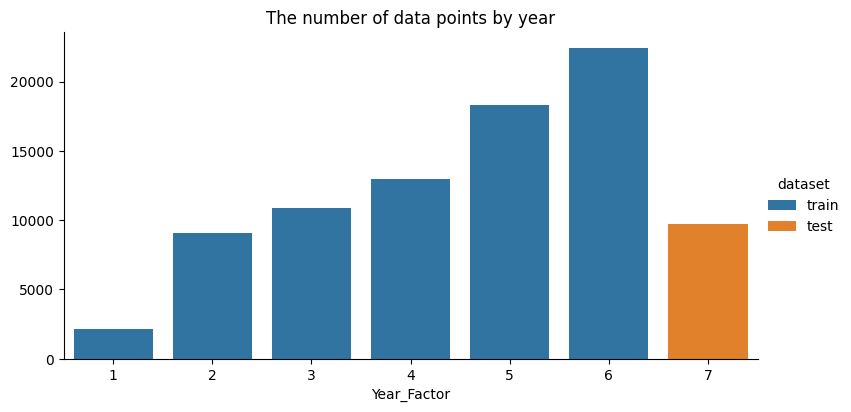

In [18]:
import seaborn as sb
# Which year has the highest energy consumption

ax = sb.catplot(x='Year_Factor', 
                 y='id', 
                 data=df_all.groupby(['dataset','Year_Factor']).agg({'id':'count'}).reset_index(),
                 hue='dataset',
                 kind='bar',
                 aspect=2,
                 height=4)\
.set(title="The number of data points by year",
     ylabel=None)

<div class="alert alert-block alert-info" style="font-size:14px; font-family:verdana; line-height: 1.7em;">
    The dataset contains time variable, `Year_Factor`, that has values from 1 to 7. Assuming the values are consecutive years,`train` dataset contains the first 6 years and `test` set contains the 7th year.</div>